# Sentiment Analysis - Natural Language Processing

### Import necessary libraries

In [1]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
#import gensim
import re


import unicodedata
tokenizer = ToktokTokenizer()
#nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

### Reading the Cleaned Dataset

In [2]:
# Read the file
df2 = pd.read_csv('C:/users/eturk/Data_Science/Capstone_Project-Sentiment_Analysis/dataset/cleaned_dataset.csv')

In [3]:
# Sample observations
df2.head(3)

,customer,product,review_text,rating_class,year,clean_text,tokens
0,A6VPK7X53QNAQ,B0000CC64W,If I had to choose only one product to take ca...,good,2009,choose one product take care face rest life wo...,"['choose', 'one', 'product', 'take', 'care', '..."
1,A3CHMHGSJSQ02J,B0000CC64W,Makes my skin lovely and smooth As a woman nea...,good,2013,make skin lovely smooth woman near need help g...,"['make', 'skin', 'lovely', 'smooth', 'woman', ..."
2,A1V1EP514B5H7Y,B0000CC64W,Works well at a reasonable price I've used thi...,good,2011,work well reasonable price use regenerating se...,"['work', 'well', 'reasonable', 'price', 'use',..."


# Natural Language Processing

## 1. Feature Engineering and Selection

Machine Learning models take numerical values as input. Our dataset is a list of sentences, so in order for our algorithm to extract patterns from the data, we first need to find a way to represent it in a way that our algorithm can understand, i.e. as a list of numbers. 

We will implement CounterVectorizer, TF-IDF, Word2Vec, adding most common words into the stopwords list, SMOTE, PCA, and Truncated SVD techniques into the our models in the following sections as a part of feature engineering and selection.

## 2. Data Preprocessing

**Separating Response Variable and Feature**

In [5]:
df2['rating_class'] = df2['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [6]:
# Splitting the Data Set into Train and Test Sets
X = df2['clean_text']
y = df2['rating_class']

**Splitting Dataset into Train and Test Set**

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data. 

In [7]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(18381,)
Test Set Shape		:(6128,)


## 3. Selecting the Right Evaluation Metric

As the data imbalance is emphasized above, the evaluation of the classifier performance must be carried out using adequate metrics in order to take into account the class distribution and to pay more attention to the minority class. When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall. For our particular case, based on this thought I will use f1 score which is harmonic average of precision and recall as my evaluation metric.

**Confusion Matrix Plot Function**

A first step is to understand the types of errors our model makes, and which kind of errors are least desirable. A good way to visualize this information is using a Confusion Matrix, which compares the predictions our model makes with the true label. Ideally, the matrix would be a diagonal line from top left to bottom right (our predictions match the truth perfectly).

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.summer):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [10]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

## 4. Modelling 

This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by females who bought beauty products in Amazon e-commerce system.  We used Python’s Scikit Learn libraries to solve our problem. In this context, we implemented Logistic Regression, Random Forest, Naive Bayes, XGBOOST, and Catboost algorithms. 

Since the ratings of the reviews were not distributed normally, we decided to decrease rating classes from 5 to 2 by merging Rating 1-2 as ‘Bad’ and Rating 4-5 as 'Good' while keeping Rating 3 is out of our model. 

In this section, we will try combinations of different vectorizer and models to get the prediction scores for text sentiment analysis. 

## 4.1 CounterVectorizer Bag of Words

Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

In order to address this, scikit-learn provides utilities for the most common ways to extract numerical features from text content, namely:

- **tokenizing** strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.

- **counting** the occurrences of tokens in each document.

- **normalizing** and weighting with diminishing importance tokens that occur in the majority of samples / documents.

In this scheme, features and samples are defined as follows:

- each **individual token occurrence frequency** (normalized or not) is treated as a feature.

- the vector of all the token frequencies for a given **document** is considered a multivariate sample.
A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

**"CountVectorizer"** implements both tokenization and occurrence counting in a single class. 

In [11]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [12]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 21808


In [15]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [16]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,___________________________________________________________i,_____________________________________________i,________________________________________product,_____________________addendum,aa,aaa,aaaaahhhhhhh,aaaah,aaaahhhh,aaack,...,zone,zoo,zoolander,zoom,zoomlash,zwill,zwilling,zync,zz,zzzzap
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Creating a function for applying different algorithms**

In [17]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

### 4.1.1 Logistic Regression with CountVectorizer

In [18]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.9229260093841383


**Classification Report**

In [19]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.50      0.73      0.59       514
           1       0.97      0.93      0.95      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.74      0.83      0.77      6128
weighted avg       0.93      0.92      0.92      6128



**Confusion Matrix**

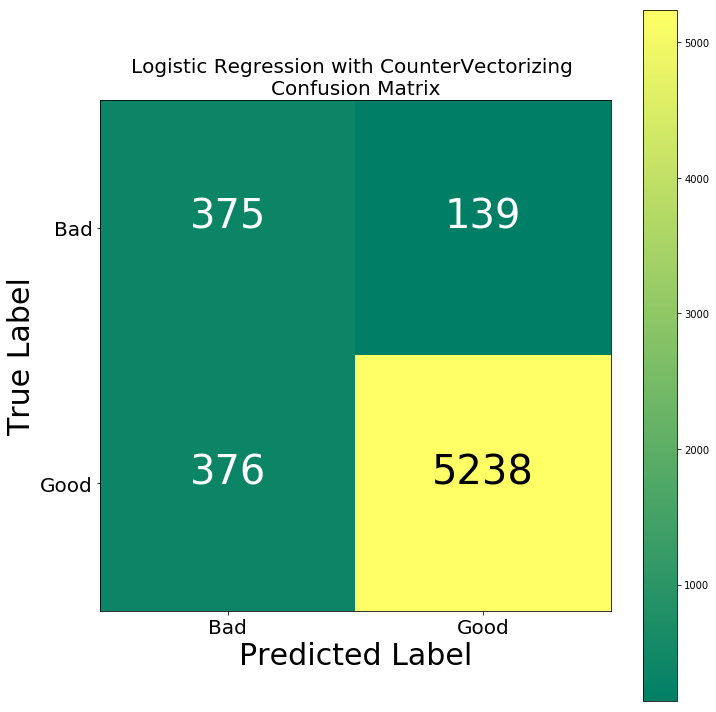

In [21]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

### 4.1.2 Random Forest with CountVectorizer

In [22]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.879188119188214


**Classification Report**

In [23]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       1.00      0.02      0.03       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.96      0.51      0.49      6128
weighted avg       0.92      0.92      0.88      6128



**Confusion Matrix**

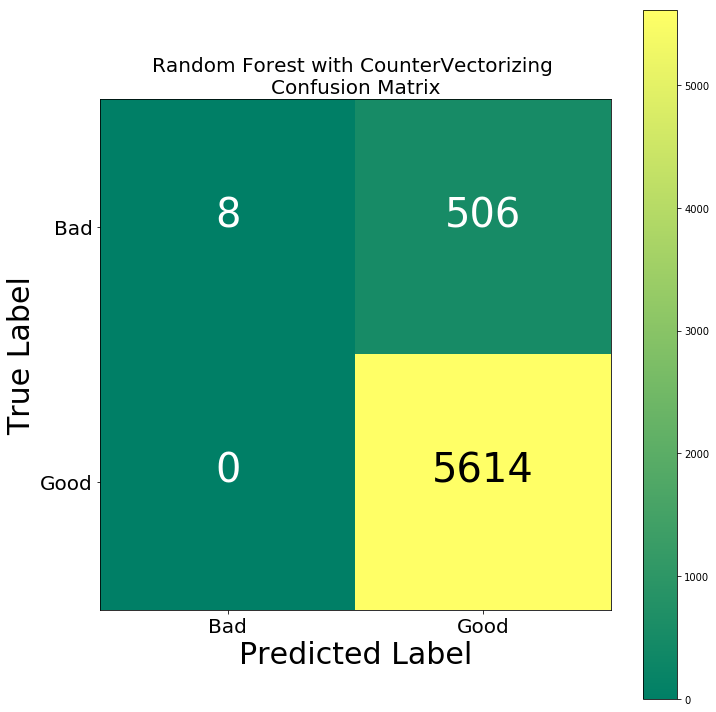

In [24]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

### 4.1.3 Naive Bayes with CountVectorizer 

In [25]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.9244233192137602


**Classification Report**

In [26]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.69      0.38      0.49       514
           1       0.95      0.98      0.96      5614

   micro avg       0.93      0.93      0.93      6128
   macro avg       0.82      0.68      0.73      6128
weighted avg       0.92      0.93      0.92      6128



**Confusion Matrix**

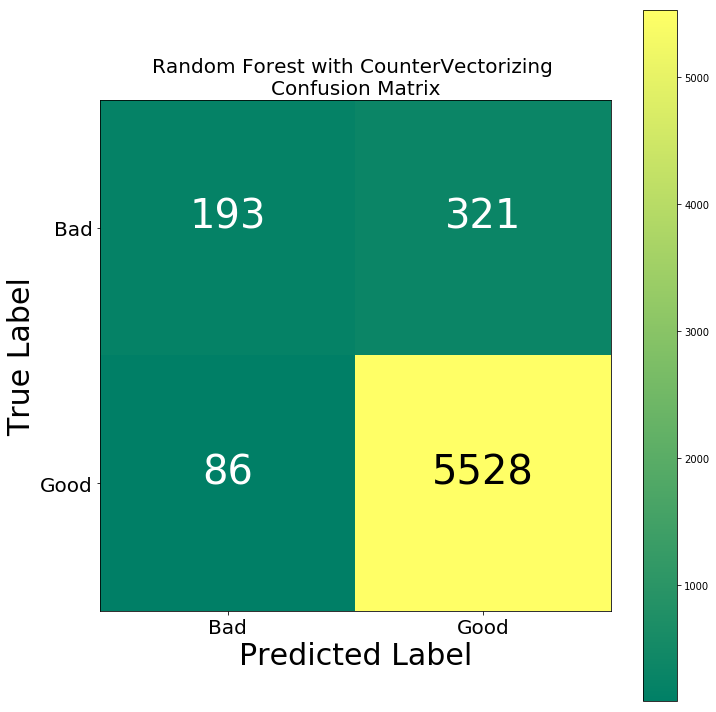

In [27]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Random Forest")

### 4.1.4 XGBoost with CountVectorizing

In [28]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.8941529692558983


**Classification Report**

In [29]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.79      0.10      0.18       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.86      0.55      0.57      6128
weighted avg       0.91      0.92      0.89      6128



**Confusion Matrix**

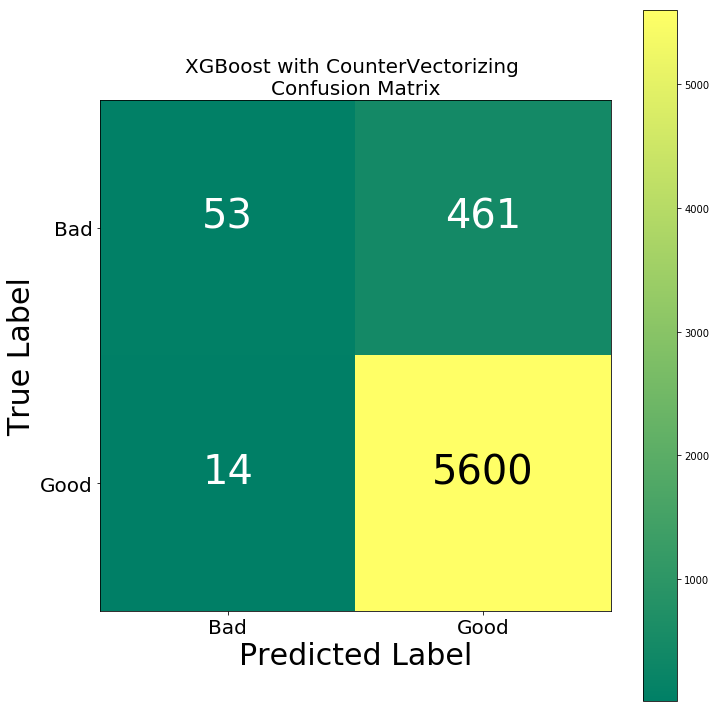

In [30]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

### 4.1.5 CatBoosting with CountVectorizing

In [31]:
# Call the modeling function for CatBoost with countvectorizer and print f1 score
modeling(CatBoostClassifier(iterations=1000, learning_rate=0.8, 
                            depth=2, loss_function='Logloss'))

# Assign y_pred to a variable for further process
y_pred_cv_catboost = y_pred

0:	learn: 0.3018452	total: 118ms	remaining: 1m 58s
1:	learn: 0.2685634	total: 192ms	remaining: 1m 35s
2:	learn: 0.2567093	total: 264ms	remaining: 1m 27s
3:	learn: 0.2496921	total: 345ms	remaining: 1m 25s
4:	learn: 0.2428042	total: 443ms	remaining: 1m 28s
5:	learn: 0.2399127	total: 514ms	remaining: 1m 25s
6:	learn: 0.2365168	total: 585ms	remaining: 1m 22s
7:	learn: 0.2304531	total: 641ms	remaining: 1m 19s
8:	learn: 0.2263375	total: 697ms	remaining: 1m 16s
9:	learn: 0.2232063	total: 754ms	remaining: 1m 14s
10:	learn: 0.2208724	total: 826ms	remaining: 1m 14s
11:	learn: 0.2182095	total: 884ms	remaining: 1m 12s
12:	learn: 0.2177957	total: 939ms	remaining: 1m 11s
13:	learn: 0.2140510	total: 997ms	remaining: 1m 10s
14:	learn: 0.2132447	total: 1.06s	remaining: 1m 9s
15:	learn: 0.2070136	total: 1.14s	remaining: 1m 9s
16:	learn: 0.2048960	total: 1.19s	remaining: 1m 9s
17:	learn: 0.2035962	total: 1.25s	remaining: 1m 8s
18:	learn: 0.2024776	total: 1.31s	remaining: 1m 7s
19:	learn: 0.2000411	total:

163:	learn: 0.1449345	total: 9.88s	remaining: 50.4s
164:	learn: 0.1447518	total: 9.94s	remaining: 50.3s
165:	learn: 0.1445748	total: 10s	remaining: 50.3s
166:	learn: 0.1441647	total: 10.1s	remaining: 50.3s
167:	learn: 0.1440285	total: 10.1s	remaining: 50.2s
168:	learn: 0.1439242	total: 10.2s	remaining: 50.2s
169:	learn: 0.1438712	total: 10.3s	remaining: 50.1s
170:	learn: 0.1437127	total: 10.3s	remaining: 50s
171:	learn: 0.1431013	total: 10.4s	remaining: 50s
172:	learn: 0.1430072	total: 10.4s	remaining: 49.9s
173:	learn: 0.1429380	total: 10.5s	remaining: 49.9s
174:	learn: 0.1428834	total: 10.6s	remaining: 49.8s
175:	learn: 0.1428444	total: 10.6s	remaining: 49.7s
176:	learn: 0.1427940	total: 10.7s	remaining: 49.7s
177:	learn: 0.1426761	total: 10.8s	remaining: 49.7s
178:	learn: 0.1426092	total: 10.8s	remaining: 49.6s
179:	learn: 0.1425771	total: 10.9s	remaining: 49.6s
180:	learn: 0.1417348	total: 10.9s	remaining: 49.5s
181:	learn: 0.1415901	total: 11s	remaining: 49.5s
182:	learn: 0.141550

323:	learn: 0.1270023	total: 19.7s	remaining: 41.1s
324:	learn: 0.1269376	total: 19.7s	remaining: 41s
325:	learn: 0.1269337	total: 19.8s	remaining: 40.9s
326:	learn: 0.1269175	total: 19.8s	remaining: 40.8s
327:	learn: 0.1269129	total: 19.9s	remaining: 40.8s
328:	learn: 0.1268715	total: 20s	remaining: 40.7s
329:	learn: 0.1268150	total: 20s	remaining: 40.6s
330:	learn: 0.1267338	total: 20.1s	remaining: 40.6s
331:	learn: 0.1266957	total: 20.1s	remaining: 40.5s
332:	learn: 0.1266473	total: 20.2s	remaining: 40.4s
333:	learn: 0.1266306	total: 20.2s	remaining: 40.4s
334:	learn: 0.1266151	total: 20.3s	remaining: 40.3s
335:	learn: 0.1265484	total: 20.4s	remaining: 40.2s
336:	learn: 0.1264291	total: 20.4s	remaining: 40.2s
337:	learn: 0.1264272	total: 20.5s	remaining: 40.1s
338:	learn: 0.1264226	total: 20.5s	remaining: 40.1s
339:	learn: 0.1263755	total: 20.6s	remaining: 40s
340:	learn: 0.1263742	total: 20.7s	remaining: 39.9s
341:	learn: 0.1263596	total: 20.7s	remaining: 39.8s
342:	learn: 0.126356

482:	learn: 0.1158277	total: 29.5s	remaining: 31.6s
483:	learn: 0.1158270	total: 29.6s	remaining: 31.6s
484:	learn: 0.1158258	total: 29.7s	remaining: 31.6s
485:	learn: 0.1158076	total: 29.8s	remaining: 31.6s
486:	learn: 0.1157854	total: 29.9s	remaining: 31.5s
487:	learn: 0.1157845	total: 30s	remaining: 31.5s
488:	learn: 0.1157807	total: 30.1s	remaining: 31.4s
489:	learn: 0.1157511	total: 30.2s	remaining: 31.4s
490:	learn: 0.1157083	total: 30.2s	remaining: 31.3s
491:	learn: 0.1156981	total: 30.3s	remaining: 31.3s
492:	learn: 0.1156851	total: 30.4s	remaining: 31.3s
493:	learn: 0.1156222	total: 30.5s	remaining: 31.3s
494:	learn: 0.1155990	total: 30.6s	remaining: 31.2s
495:	learn: 0.1155911	total: 30.7s	remaining: 31.2s
496:	learn: 0.1155018	total: 30.8s	remaining: 31.1s
497:	learn: 0.1154791	total: 30.8s	remaining: 31.1s
498:	learn: 0.1154664	total: 30.9s	remaining: 31s
499:	learn: 0.1154661	total: 30.9s	remaining: 30.9s
500:	learn: 0.1153885	total: 31s	remaining: 30.9s
501:	learn: 0.1153

641:	learn: 0.1068822	total: 39.4s	remaining: 21.9s
642:	learn: 0.1068735	total: 39.4s	remaining: 21.9s
643:	learn: 0.1068631	total: 39.5s	remaining: 21.8s
644:	learn: 0.1068324	total: 39.5s	remaining: 21.7s
645:	learn: 0.1068209	total: 39.6s	remaining: 21.7s
646:	learn: 0.1068162	total: 39.6s	remaining: 21.6s
647:	learn: 0.1068150	total: 39.7s	remaining: 21.5s
648:	learn: 0.1067902	total: 39.7s	remaining: 21.5s
649:	learn: 0.1067703	total: 39.8s	remaining: 21.4s
650:	learn: 0.1066172	total: 39.8s	remaining: 21.3s
651:	learn: 0.1065311	total: 39.9s	remaining: 21.3s
652:	learn: 0.1063084	total: 39.9s	remaining: 21.2s
653:	learn: 0.1062969	total: 40s	remaining: 21.1s
654:	learn: 0.1062487	total: 40s	remaining: 21.1s
655:	learn: 0.1061891	total: 40.1s	remaining: 21s
656:	learn: 0.1061670	total: 40.1s	remaining: 21s
657:	learn: 0.1061669	total: 40.2s	remaining: 20.9s
658:	learn: 0.1061664	total: 40.2s	remaining: 20.8s
659:	learn: 0.1061646	total: 40.3s	remaining: 20.8s
660:	learn: 0.106162

803:	learn: 0.1010519	total: 47.7s	remaining: 11.6s
804:	learn: 0.1010446	total: 47.7s	remaining: 11.6s
805:	learn: 0.1010413	total: 47.8s	remaining: 11.5s
806:	learn: 0.1010404	total: 47.8s	remaining: 11.4s
807:	learn: 0.1010262	total: 47.9s	remaining: 11.4s
808:	learn: 0.1010125	total: 47.9s	remaining: 11.3s
809:	learn: 0.1010084	total: 48s	remaining: 11.3s
810:	learn: 0.1010079	total: 48s	remaining: 11.2s
811:	learn: 0.1010052	total: 48.1s	remaining: 11.1s
812:	learn: 0.1009704	total: 48.1s	remaining: 11.1s
813:	learn: 0.1009702	total: 48.2s	remaining: 11s
814:	learn: 0.1009089	total: 48.2s	remaining: 10.9s
815:	learn: 0.1008862	total: 48.3s	remaining: 10.9s
816:	learn: 0.1008852	total: 48.3s	remaining: 10.8s
817:	learn: 0.1008826	total: 48.4s	remaining: 10.8s
818:	learn: 0.1008816	total: 48.4s	remaining: 10.7s
819:	learn: 0.1008791	total: 48.5s	remaining: 10.6s
820:	learn: 0.1008747	total: 48.5s	remaining: 10.6s
821:	learn: 0.1008646	total: 48.6s	remaining: 10.5s
822:	learn: 0.1008

965:	learn: 0.0977533	total: 56s	remaining: 1.97s
966:	learn: 0.0977220	total: 56s	remaining: 1.91s
967:	learn: 0.0976778	total: 56.1s	remaining: 1.85s
968:	learn: 0.0976405	total: 56.1s	remaining: 1.79s
969:	learn: 0.0976399	total: 56.2s	remaining: 1.74s
970:	learn: 0.0976047	total: 56.2s	remaining: 1.68s
971:	learn: 0.0976043	total: 56.3s	remaining: 1.62s
972:	learn: 0.0976043	total: 56.3s	remaining: 1.56s
973:	learn: 0.0976011	total: 56.4s	remaining: 1.5s
974:	learn: 0.0975985	total: 56.4s	remaining: 1.45s
975:	learn: 0.0975972	total: 56.5s	remaining: 1.39s
976:	learn: 0.0975961	total: 56.5s	remaining: 1.33s
977:	learn: 0.0975811	total: 56.6s	remaining: 1.27s
978:	learn: 0.0975773	total: 56.6s	remaining: 1.21s
979:	learn: 0.0975656	total: 56.7s	remaining: 1.16s
980:	learn: 0.0975515	total: 56.7s	remaining: 1.1s
981:	learn: 0.0975514	total: 56.8s	remaining: 1.04s
982:	learn: 0.0975252	total: 56.8s	remaining: 983ms
983:	learn: 0.0974701	total: 56.9s	remaining: 925ms
984:	learn: 0.0974

**Classification Report**

In [32]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.61      0.39      0.47       514
           1       0.95      0.98      0.96      5614

   micro avg       0.93      0.93      0.93      6128
   macro avg       0.78      0.68      0.72      6128
weighted avg       0.92      0.93      0.92      6128



**Confusion Matrix**

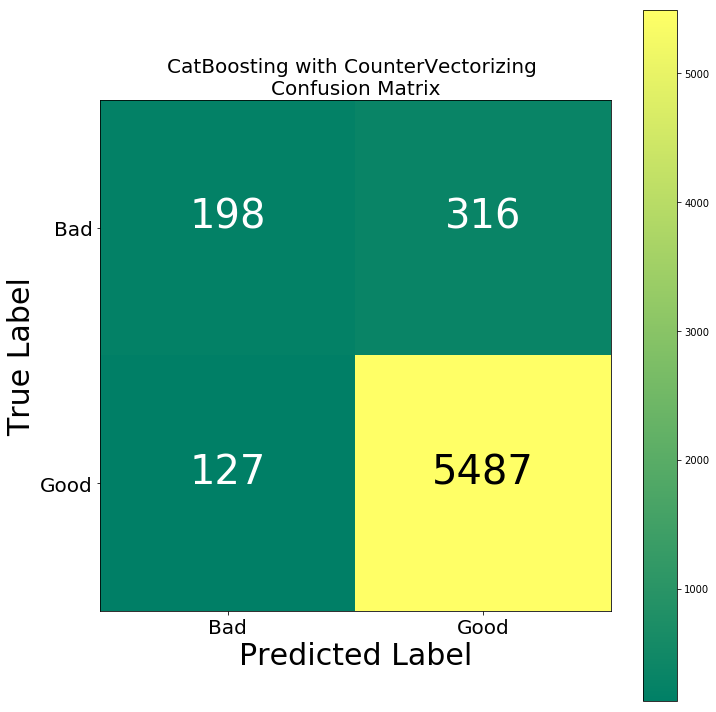

In [33]:
# Print confusion matrix for CatBoost with countVectorizer
disp_confusion_matrix(y_pred_cv_catboost, "CatBoosting")

### 4.1.6 Comparison of CountVectorizing

**Functions for Algorithms Comparison**

In [34]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [35]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

**Function for f1 Score Plotting**

In [38]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

**Algorithms Comparison with CountVectorizing**

In [59]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

In [39]:
df_cv2

precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.915960 bad       0.499334  0.729572  0.592885   
                                  good      0.974149  0.933025  0.953143   
                                  average   0.934323  0.915960  0.922926   
           Random Forest 0.917428 bad       1.000000  0.015564  0.030651   
                                  good      0.917320  1.000000  0.956877   
                                  average   0.924255  0.917428  0.879188   
           Naive Bayes   0.933584 bad       0.691756  0.375486  0.486759   
                                  good      0.945119  0.984681  0.964494   
                                  average   0.923867  0.933584  0.924423   
           XGBoost       0.922487 bad       0.791045  0.103113  0.182444   
                                  good      0.923940  0.997506  0.959315   
                                  average   0.912793  0.922487  0.894153   
           CatBoost      0.927709 bad       0.609231  0.385214  0.471990   
                                  good      0.945545  0.977378  0.961198   
                                  average   0.917336  0.927709  0.920165   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.915960 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.917428 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.933584 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.922487 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.927709 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 Score - CountVectorizing**

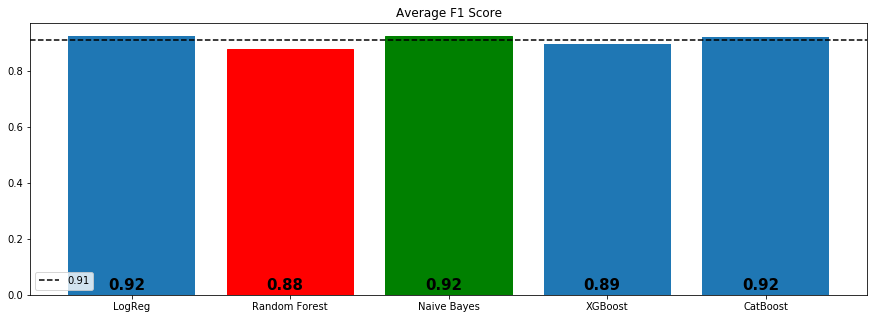

In [40]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_cv, category='average', title= "Average F1 Score")

## 4.2 TF-IDF Bag of Words 

In order to help our model focus more on meaningful words, we can use a TF-IDF score (Term Frequency, Inverse Document Frequency) on top of our Bag of Words model. TF-IDF weighs words by how rare they are in our dataset, discounting words that are too frequent and just add to the noise.

In [41]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

### 4.2.1 Logistic Regression with TF-IDF

In [42]:
# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.8949011705776584


**Classification Report**

In [43]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.39      0.84      0.53       514
           1       0.98      0.88      0.93      5614

   micro avg       0.88      0.88      0.88      6128
   macro avg       0.69      0.86      0.73      6128
weighted avg       0.93      0.88      0.89      6128



**Confusion Matrix**

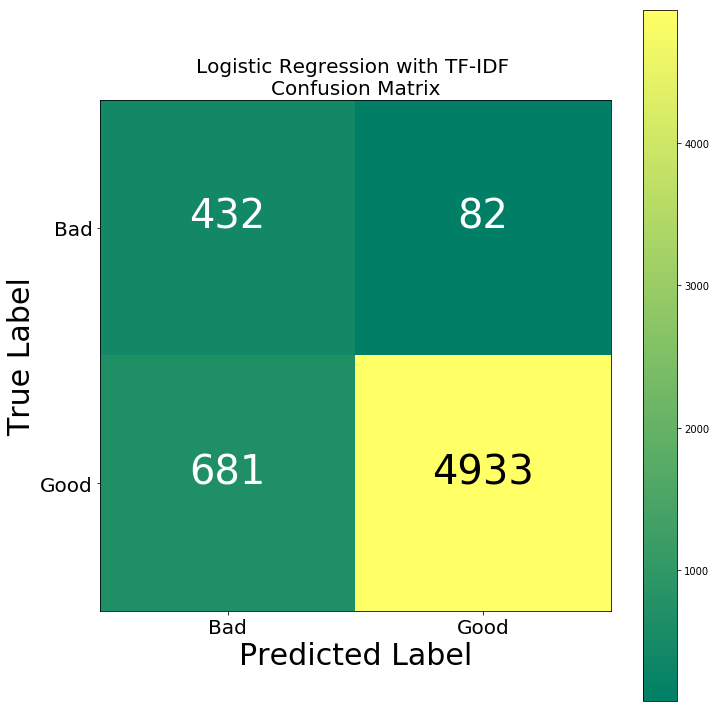

In [44]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

### 4.2.2 Random Forest with TF-IDF

In [45]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.8787963670186205


**Classification Report**

In [46]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       1.00      0.01      0.03       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.96      0.51      0.49      6128
weighted avg       0.92      0.92      0.88      6128



**Confusion Matrix**

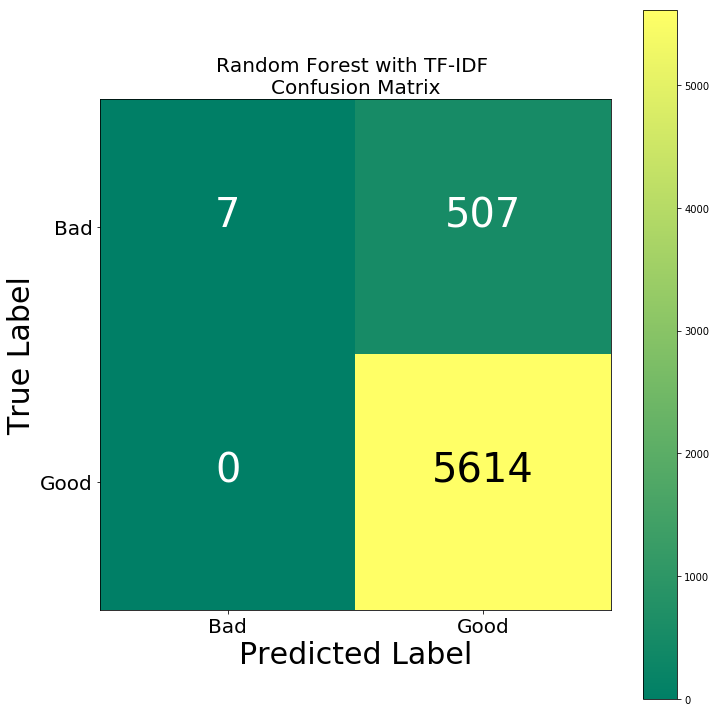

In [47]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

### 4.2.3 Naive Bayes with TF-IDF

In [48]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.8760199155649777


**Classification Report**

In [49]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       514
           1       0.92      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.46      0.50      0.48      6128
weighted avg       0.84      0.92      0.88      6128



**Confusion Matrix**

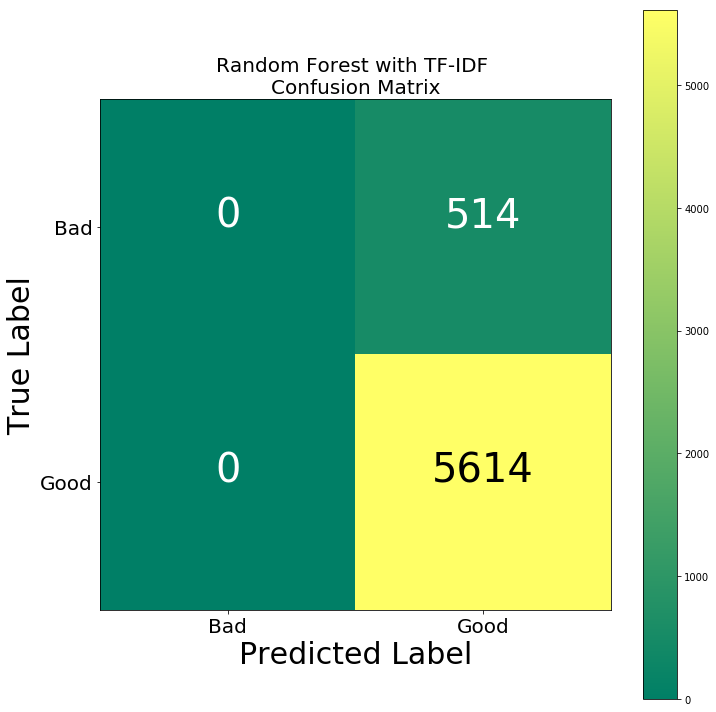

In [50]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Random Forest", "TF-IDF")

### 4.2.4 XGBoost with TF-IDF

In [51]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

f1 score: 0.8971422869530663


**Classification Report**

In [49]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.76      0.12      0.21       514
           1       0.93      1.00      0.96      5614

   micro avg       0.92      0.92      0.92      6128
   macro avg       0.84      0.56      0.59      6128
weighted avg       0.91      0.92      0.90      6128



**Confusion Matrix**

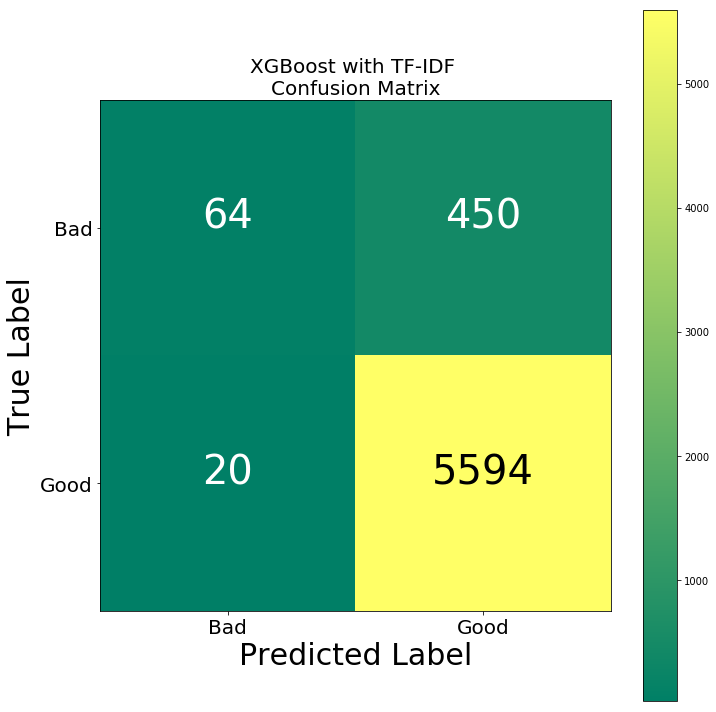

In [52]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

### 4.2.5 Catboosting with TF-IDF

In [53]:
# Call the modeling function for Catboost with TF-IDF and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_catboost = y_pred

0:	learn: 0.3016853	total: 110ms	remaining: 2m 44s
1:	learn: 0.2722303	total: 224ms	remaining: 2m 47s
2:	learn: 0.2660376	total: 324ms	remaining: 2m 41s
3:	learn: 0.2576710	total: 425ms	remaining: 2m 39s
4:	learn: 0.2480941	total: 524ms	remaining: 2m 36s
5:	learn: 0.2448914	total: 607ms	remaining: 2m 31s
6:	learn: 0.2379666	total: 678ms	remaining: 2m 24s
7:	learn: 0.2314107	total: 770ms	remaining: 2m 23s
8:	learn: 0.2290738	total: 843ms	remaining: 2m 19s
9:	learn: 0.2262923	total: 925ms	remaining: 2m 17s
10:	learn: 0.2245334	total: 1.01s	remaining: 2m 16s
11:	learn: 0.2226709	total: 1.09s	remaining: 2m 15s
12:	learn: 0.2163520	total: 1.17s	remaining: 2m 14s
13:	learn: 0.2144680	total: 1.26s	remaining: 2m 13s
14:	learn: 0.2106532	total: 1.34s	remaining: 2m 12s
15:	learn: 0.2075915	total: 1.42s	remaining: 2m 11s
16:	learn: 0.2064084	total: 1.5s	remaining: 2m 11s
17:	learn: 0.2029201	total: 1.58s	remaining: 2m 10s
18:	learn: 0.2017956	total: 1.66s	remaining: 2m 9s
19:	learn: 0.2004559	tot

159:	learn: 0.1373580	total: 13.2s	remaining: 1m 50s
160:	learn: 0.1371775	total: 13.3s	remaining: 1m 50s
161:	learn: 0.1370965	total: 13.4s	remaining: 1m 50s
162:	learn: 0.1368535	total: 13.5s	remaining: 1m 50s
163:	learn: 0.1366415	total: 13.6s	remaining: 1m 50s
164:	learn: 0.1365408	total: 13.6s	remaining: 1m 50s
165:	learn: 0.1364659	total: 13.7s	remaining: 1m 50s
166:	learn: 0.1363370	total: 13.8s	remaining: 1m 50s
167:	learn: 0.1361145	total: 13.9s	remaining: 1m 50s
168:	learn: 0.1357721	total: 14s	remaining: 1m 49s
169:	learn: 0.1356272	total: 14s	remaining: 1m 49s
170:	learn: 0.1354712	total: 14.1s	remaining: 1m 49s
171:	learn: 0.1352240	total: 14.2s	remaining: 1m 49s
172:	learn: 0.1349541	total: 14.3s	remaining: 1m 49s
173:	learn: 0.1348742	total: 14.4s	remaining: 1m 49s
174:	learn: 0.1347375	total: 14.4s	remaining: 1m 49s
175:	learn: 0.1346536	total: 14.5s	remaining: 1m 49s
176:	learn: 0.1344993	total: 14.6s	remaining: 1m 49s
177:	learn: 0.1343541	total: 14.7s	remaining: 1m 4

315:	learn: 0.1152291	total: 25.7s	remaining: 1m 36s
316:	learn: 0.1149991	total: 25.8s	remaining: 1m 36s
317:	learn: 0.1148664	total: 25.9s	remaining: 1m 36s
318:	learn: 0.1147676	total: 25.9s	remaining: 1m 36s
319:	learn: 0.1147600	total: 26s	remaining: 1m 35s
320:	learn: 0.1147109	total: 26.1s	remaining: 1m 35s
321:	learn: 0.1146830	total: 26.2s	remaining: 1m 35s
322:	learn: 0.1144937	total: 26.2s	remaining: 1m 35s
323:	learn: 0.1144589	total: 26.3s	remaining: 1m 35s
324:	learn: 0.1142463	total: 26.4s	remaining: 1m 35s
325:	learn: 0.1141882	total: 26.5s	remaining: 1m 35s
326:	learn: 0.1141700	total: 26.5s	remaining: 1m 35s
327:	learn: 0.1140899	total: 26.6s	remaining: 1m 35s
328:	learn: 0.1140761	total: 26.7s	remaining: 1m 34s
329:	learn: 0.1140317	total: 26.7s	remaining: 1m 34s
330:	learn: 0.1140061	total: 26.8s	remaining: 1m 34s
331:	learn: 0.1139671	total: 26.9s	remaining: 1m 34s
332:	learn: 0.1139333	total: 27s	remaining: 1m 34s
333:	learn: 0.1139304	total: 27.1s	remaining: 1m 3

471:	learn: 0.1015961	total: 37.6s	remaining: 1m 21s
472:	learn: 0.1015882	total: 37.7s	remaining: 1m 21s
473:	learn: 0.1014990	total: 37.8s	remaining: 1m 21s
474:	learn: 0.1014917	total: 37.9s	remaining: 1m 21s
475:	learn: 0.1013522	total: 38s	remaining: 1m 21s
476:	learn: 0.1009711	total: 38s	remaining: 1m 21s
477:	learn: 0.1008677	total: 38.1s	remaining: 1m 21s
478:	learn: 0.1007288	total: 38.2s	remaining: 1m 21s
479:	learn: 0.1007233	total: 38.3s	remaining: 1m 21s
480:	learn: 0.1004821	total: 38.3s	remaining: 1m 21s
481:	learn: 0.1003941	total: 38.4s	remaining: 1m 21s
482:	learn: 0.1003861	total: 38.5s	remaining: 1m 21s
483:	learn: 0.1003797	total: 38.6s	remaining: 1m 21s
484:	learn: 0.1003634	total: 38.7s	remaining: 1m 20s
485:	learn: 0.1003614	total: 38.7s	remaining: 1m 20s
486:	learn: 0.1003140	total: 38.8s	remaining: 1m 20s
487:	learn: 0.1001654	total: 38.9s	remaining: 1m 20s
488:	learn: 0.1001125	total: 39s	remaining: 1m 20s
489:	learn: 0.1001086	total: 39s	remaining: 1m 20s
4

627:	learn: 0.0938003	total: 49.3s	remaining: 1m 8s
628:	learn: 0.0937973	total: 49.4s	remaining: 1m 8s
629:	learn: 0.0937956	total: 49.4s	remaining: 1m 8s
630:	learn: 0.0937860	total: 49.5s	remaining: 1m 8s
631:	learn: 0.0935729	total: 49.6s	remaining: 1m 8s
632:	learn: 0.0934608	total: 49.7s	remaining: 1m 8s
633:	learn: 0.0932490	total: 49.8s	remaining: 1m 7s
634:	learn: 0.0932488	total: 49.8s	remaining: 1m 7s
635:	learn: 0.0932453	total: 49.9s	remaining: 1m 7s
636:	learn: 0.0932350	total: 50s	remaining: 1m 7s
637:	learn: 0.0931644	total: 50s	remaining: 1m 7s
638:	learn: 0.0931570	total: 50.1s	remaining: 1m 7s
639:	learn: 0.0931055	total: 50.2s	remaining: 1m 7s
640:	learn: 0.0930760	total: 50.3s	remaining: 1m 7s
641:	learn: 0.0930737	total: 50.3s	remaining: 1m 7s
642:	learn: 0.0930170	total: 50.4s	remaining: 1m 7s
643:	learn: 0.0929897	total: 50.5s	remaining: 1m 7s
644:	learn: 0.0928878	total: 50.6s	remaining: 1m 7s
645:	learn: 0.0928603	total: 50.6s	remaining: 1m 6s
646:	learn: 0.09

789:	learn: 0.0880036	total: 1m 1s	remaining: 55.1s
790:	learn: 0.0879988	total: 1m 1s	remaining: 55s
791:	learn: 0.0879840	total: 1m 1s	remaining: 54.9s
792:	learn: 0.0879469	total: 1m 1s	remaining: 54.8s
793:	learn: 0.0878877	total: 1m 1s	remaining: 54.7s
794:	learn: 0.0878287	total: 1m 1s	remaining: 54.6s
795:	learn: 0.0878257	total: 1m 1s	remaining: 54.6s
796:	learn: 0.0878226	total: 1m 1s	remaining: 54.5s
797:	learn: 0.0876505	total: 1m 1s	remaining: 54.4s
798:	learn: 0.0875692	total: 1m 1s	remaining: 54.3s
799:	learn: 0.0875683	total: 1m 1s	remaining: 54.2s
800:	learn: 0.0875506	total: 1m 2s	remaining: 54.1s
801:	learn: 0.0873667	total: 1m 2s	remaining: 54.1s
802:	learn: 0.0873530	total: 1m 2s	remaining: 54s
803:	learn: 0.0873357	total: 1m 2s	remaining: 53.9s
804:	learn: 0.0873253	total: 1m 2s	remaining: 53.8s
805:	learn: 0.0871888	total: 1m 2s	remaining: 53.8s
806:	learn: 0.0871528	total: 1m 2s	remaining: 53.7s
807:	learn: 0.0870939	total: 1m 2s	remaining: 53.6s
808:	learn: 0.08

948:	learn: 0.0803983	total: 1m 13s	remaining: 42.5s
949:	learn: 0.0803949	total: 1m 13s	remaining: 42.4s
950:	learn: 0.0803939	total: 1m 13s	remaining: 42.3s
951:	learn: 0.0803864	total: 1m 13s	remaining: 42.2s
952:	learn: 0.0803832	total: 1m 13s	remaining: 42.2s
953:	learn: 0.0803039	total: 1m 13s	remaining: 42.1s
954:	learn: 0.0802462	total: 1m 13s	remaining: 42s
955:	learn: 0.0802434	total: 1m 13s	remaining: 41.9s
956:	learn: 0.0801672	total: 1m 13s	remaining: 41.8s
957:	learn: 0.0800871	total: 1m 13s	remaining: 41.8s
958:	learn: 0.0800543	total: 1m 13s	remaining: 41.7s
959:	learn: 0.0800533	total: 1m 13s	remaining: 41.6s
960:	learn: 0.0800489	total: 1m 14s	remaining: 41.5s
961:	learn: 0.0799974	total: 1m 14s	remaining: 41.4s
962:	learn: 0.0799900	total: 1m 14s	remaining: 41.4s
963:	learn: 0.0799851	total: 1m 14s	remaining: 41.3s
964:	learn: 0.0799848	total: 1m 14s	remaining: 41.2s
965:	learn: 0.0799840	total: 1m 14s	remaining: 41.1s
966:	learn: 0.0799817	total: 1m 14s	remaining: 4

1104:	learn: 0.0756441	total: 1m 24s	remaining: 30.2s
1105:	learn: 0.0756419	total: 1m 24s	remaining: 30.1s
1106:	learn: 0.0756299	total: 1m 24s	remaining: 30s
1107:	learn: 0.0756103	total: 1m 24s	remaining: 30s
1108:	learn: 0.0755900	total: 1m 24s	remaining: 29.9s
1109:	learn: 0.0755431	total: 1m 24s	remaining: 29.8s
1110:	learn: 0.0755357	total: 1m 24s	remaining: 29.7s
1111:	learn: 0.0755343	total: 1m 24s	remaining: 29.7s
1112:	learn: 0.0755341	total: 1m 25s	remaining: 29.6s
1113:	learn: 0.0755333	total: 1m 25s	remaining: 29.5s
1114:	learn: 0.0755299	total: 1m 25s	remaining: 29.4s
1115:	learn: 0.0755146	total: 1m 25s	remaining: 29.3s
1116:	learn: 0.0755142	total: 1m 25s	remaining: 29.3s
1117:	learn: 0.0755134	total: 1m 25s	remaining: 29.2s
1118:	learn: 0.0755059	total: 1m 25s	remaining: 29.1s
1119:	learn: 0.0754633	total: 1m 25s	remaining: 29s
1120:	learn: 0.0754627	total: 1m 25s	remaining: 29s
1121:	learn: 0.0754543	total: 1m 25s	remaining: 28.9s
1122:	learn: 0.0754535	total: 1m 25s

1258:	learn: 0.0721492	total: 1m 36s	remaining: 18.4s
1259:	learn: 0.0720837	total: 1m 36s	remaining: 18.3s
1260:	learn: 0.0720824	total: 1m 36s	remaining: 18.3s
1261:	learn: 0.0720704	total: 1m 36s	remaining: 18.2s
1262:	learn: 0.0720595	total: 1m 36s	remaining: 18.1s
1263:	learn: 0.0719438	total: 1m 36s	remaining: 18s
1264:	learn: 0.0718817	total: 1m 36s	remaining: 18s
1265:	learn: 0.0718817	total: 1m 36s	remaining: 17.9s
1266:	learn: 0.0718673	total: 1m 36s	remaining: 17.8s
1267:	learn: 0.0718513	total: 1m 36s	remaining: 17.7s
1268:	learn: 0.0718510	total: 1m 36s	remaining: 17.6s
1269:	learn: 0.0718425	total: 1m 37s	remaining: 17.6s
1270:	learn: 0.0718425	total: 1m 37s	remaining: 17.5s
1271:	learn: 0.0718424	total: 1m 37s	remaining: 17.4s
1272:	learn: 0.0718326	total: 1m 37s	remaining: 17.3s
1273:	learn: 0.0718316	total: 1m 37s	remaining: 17.3s
1274:	learn: 0.0718131	total: 1m 37s	remaining: 17.2s
1275:	learn: 0.0717995	total: 1m 37s	remaining: 17.1s
1276:	learn: 0.0717563	total: 1m

1411:	learn: 0.0687622	total: 1m 47s	remaining: 6.69s
1412:	learn: 0.0687597	total: 1m 47s	remaining: 6.62s
1413:	learn: 0.0685621	total: 1m 47s	remaining: 6.54s
1414:	learn: 0.0685529	total: 1m 47s	remaining: 6.46s
1415:	learn: 0.0685477	total: 1m 47s	remaining: 6.39s
1416:	learn: 0.0685219	total: 1m 47s	remaining: 6.31s
1417:	learn: 0.0685217	total: 1m 47s	remaining: 6.24s
1418:	learn: 0.0685070	total: 1m 47s	remaining: 6.16s
1419:	learn: 0.0684618	total: 1m 47s	remaining: 6.08s
1420:	learn: 0.0683904	total: 1m 48s	remaining: 6.01s
1421:	learn: 0.0683617	total: 1m 48s	remaining: 5.93s
1422:	learn: 0.0683606	total: 1m 48s	remaining: 5.85s
1423:	learn: 0.0683554	total: 1m 48s	remaining: 5.78s
1424:	learn: 0.0683327	total: 1m 48s	remaining: 5.7s
1425:	learn: 0.0683031	total: 1m 48s	remaining: 5.63s
1426:	learn: 0.0682216	total: 1m 48s	remaining: 5.55s
1427:	learn: 0.0681661	total: 1m 48s	remaining: 5.47s
1428:	learn: 0.0681645	total: 1m 48s	remaining: 5.4s
1429:	learn: 0.0681645	total: 

**Classification Report**

In [54]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_catboost))

              precision    recall  f1-score   support

           0       0.59      0.39      0.47       514
           1       0.95      0.98      0.96      5614

   micro avg       0.93      0.93      0.93      6128
   macro avg       0.77      0.68      0.71      6128
weighted avg       0.92      0.93      0.92      6128



**Confusion Matrix**

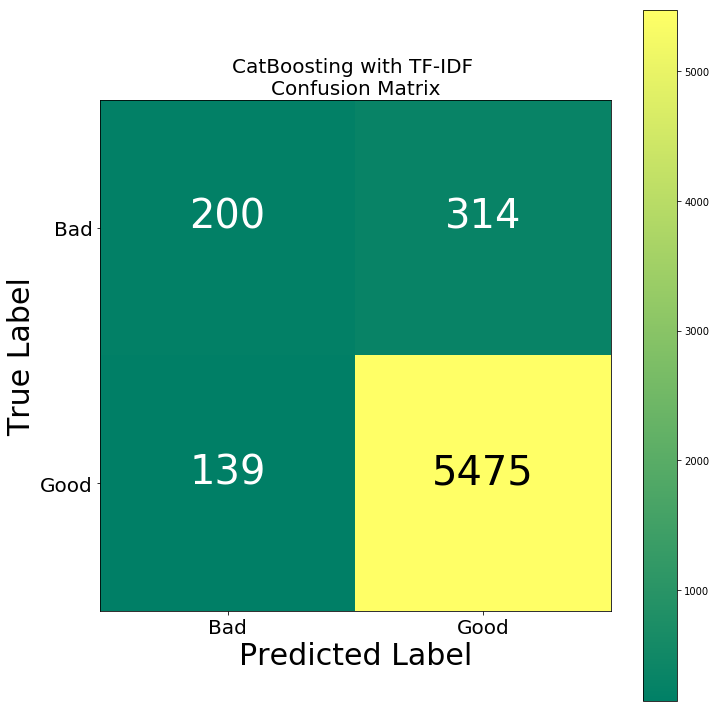

In [55]:
# Print confusion matrix for CatBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_catboost, "CatBoosting", "TF-IDF")

### 4.2.6 Comparision of TF-IDF Vectorizing

In [56]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb, y_pred_tfidf_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

**Comparison Table - TF-IDF Vectorizing**

In [57]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with TfidfVectorizing\n')
df_tv2


Comparision Matrix of Modeling with TfidfVectorizing



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
TfidfVect  LogReg        0.875490 bad       0.388140  0.840467  0.531039   
                                  good      0.983649  0.878696  0.928215   
                                  average   0.933699  0.875490  0.894901   
           Random Forest 0.917265 bad       1.000000  0.013619  0.026871   
                                  good      0.917170  1.000000  0.956796   
                                  average   0.924118  0.917265  0.878796   
           Naive Bayes   0.916123 bad       0.000000  0.000000  0.000000   
                                  good      0.916123  1.000000  0.956226   
                                  average   0.839281  0.916123  0.876020   
           XGBoost       0.923303 bad       0.761905  0.124514  0.214047   
                                  good      0.925546  0.996437  0.959684   
                                  average   0.911820  0.923303  0.897142   
           CatBoost      0.926077 bad       0.589971  0.389105  0.468933   
                                  good      0.945759  0.975240  0.960274   
                                  average   0.915917  0.926077  0.919061   

                                           support  
vectorizer model         accuracy class             
TfidfVect  LogReg        0.875490 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.917265 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.916123 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.923303 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.926077 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 score - TF-IDF Vectorizing**

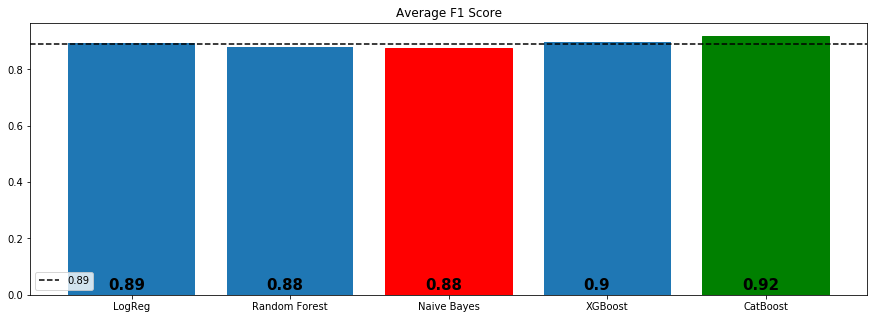

In [58]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")